<a href="https://colab.research.google.com/github/He1laGR/MAI_predictive_analytics/blob/main/predective_analytics_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
td = pd.read_csv('train.csv')

## **EDA**

In [3]:
td.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [4]:
td = td.drop(['store', 'product'], axis = 1)

In [5]:
td.dtypes

,0
Date,object
number_sold,int64


In [6]:
td['Date'] = pd.to_datetime(td['Date'])

In [7]:
td.head()

,Date,number_sold
0,2010-01-01,801
1,2010-01-02,810
2,2010-01-03,818
3,2010-01-04,796
4,2010-01-05,808


In [8]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         230090 non-null  datetime64[ns]
 1   number_sold  230090 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.5 MB


In [9]:
td.describe()

,Date,number_sold
count,230090,230090.000000
mean,2014-07-01 23:59:59.999999744,780.926107
min,2010-01-01 00:00:00,238.000000
25%,2012-04-01 00:00:00,722.000000
50%,2014-07-02 00:00:00,835.000000
75%,2016-10-01 00:00:00,914.000000
max,2018-12-31 00:00:00,1205.000000
std,NaN,204.096737


In [10]:
td.set_index('Date', inplace=True)

In [32]:
monthly_sales = td.resample('ME')['number_sold'].mean()

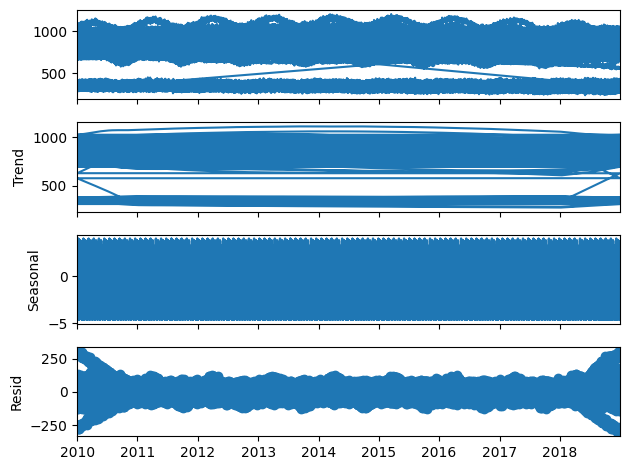

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(td, period=720)
decompose.plot()

plt.show()

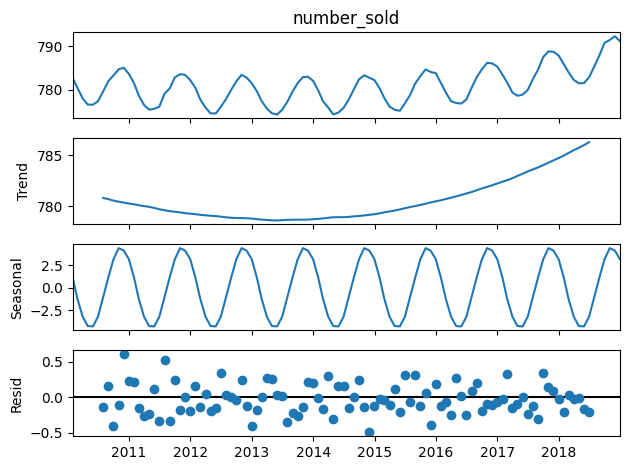

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(monthly_sales, period=12)
decompose.plot()

plt.show()

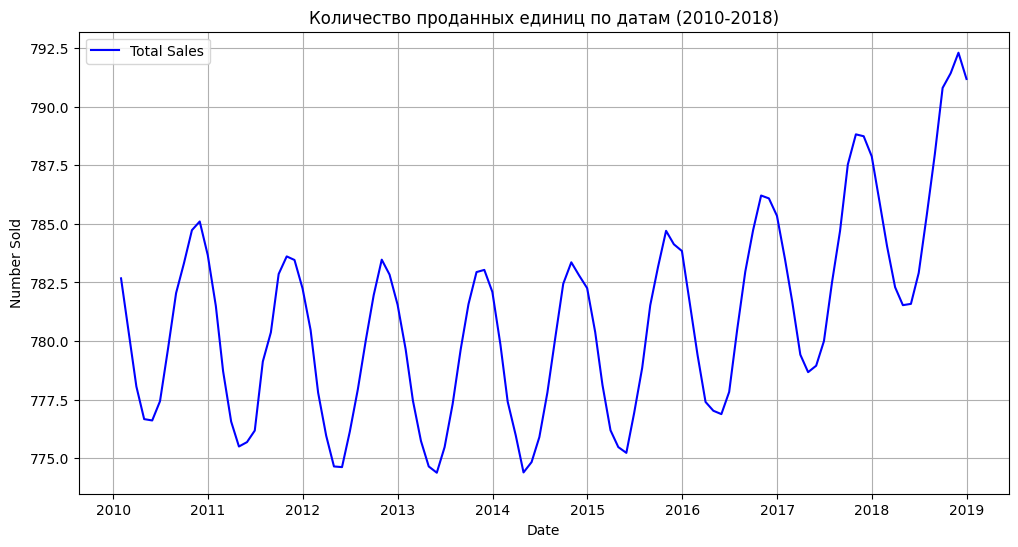

In [34]:
# Plot daily sales over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Total Sales', color='b')
plt.title('Количество проданных единиц по датам (2010-2018)')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.legend()
plt.grid(True)
plt.show()

На графике видно что ряд не стационарен с выраженной сезонностью, где количество продаж растет во второй половине года и падает в первой половине, после 2014 наблюдается тренд, для подтверждения воспользуемся тестом Дики-Фуллера. Если значение p меньше уровня значимости 0.05 в результате теста, то основная гипотеза (ряд не стационарен) отвергается, и ряд может считаться стационарным.

## Preparing

In [38]:
from statsmodels.tsa.stattools import adfuller

print('Результат теста:')
df_result = adfuller(monthly_sales)
df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
for result_value, label in zip(df_result, df_labels):
    print(label + ' : ' + str(result_value))

if df_result[1] <= 0.05:
    print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
else:
    print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")

Результат теста:
ADF Test Statistic : 1.3364583375975922
p-value : 0.9968054673009306
#Lags Used : 13
Number of Observations Used : 94
Слабые доказательства против нулевой гипотезы, ряд не является стационарным.


Приводим ряд к стационарности (выясняем параметр d)

ADF statisctic diff: -0.1833430118921186
p-value: 0.9404781800020883


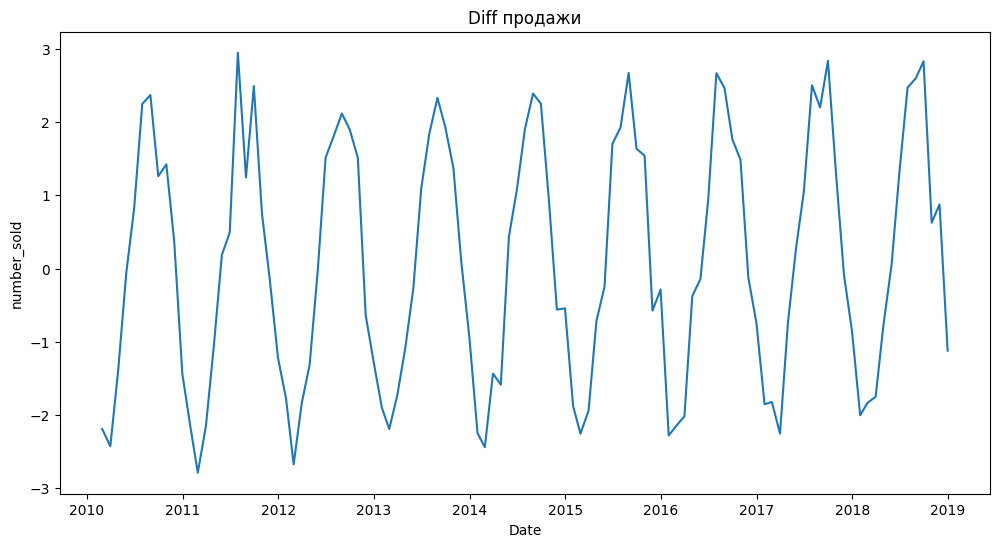

In [ ]:
monthly_sales_diff = monthly_sales.diff().dropna()
res_diff = adfuller(monthly_sales_diff)

print(f'ADF statisctic diff: {res_diff[0]}')
print(f'p-value: {res_diff[1]}')

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales_diff)
plt.title('Diff продажи')
plt.show()

ADF statisctic diff: -9.39592270179115
p-value: 6.374995213957317e-16


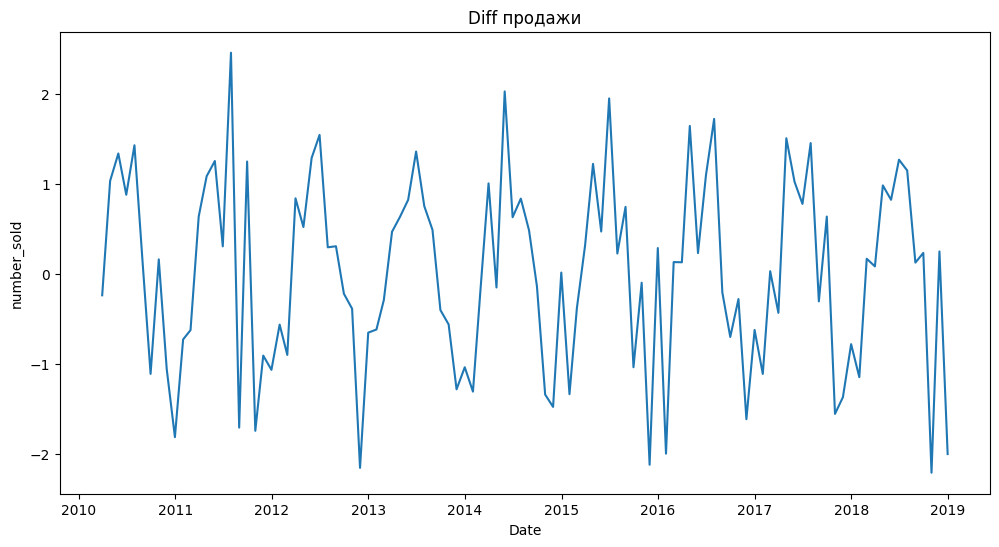

In [ ]:
monthly_sales_diff2 = monthly_sales_diff.diff().dropna()
res_diff2 = adfuller(monthly_sales_diff2)

print(f'ADF statisctic diff: {res_diff2[0]}')
print(f'p-value: {res_diff2[1]}')

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales_diff2)
plt.title('Diff продажи')
plt.show()

In [ ]:
def check_stationarity(timeseries):
	# Perform the Dickey-Fuller test
	result = adfuller(timeseries, autolag='AIC')
	p_value = result[1]
	print(f'ADF Statistic: {result[0]}')
	print(f'p-value: {p_value}')
	print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(monthly_sales_diff2)


ADF Statistic: -9.39592270179115
p-value: 6.374995213957317e-16
Stationary


Добились стационарности

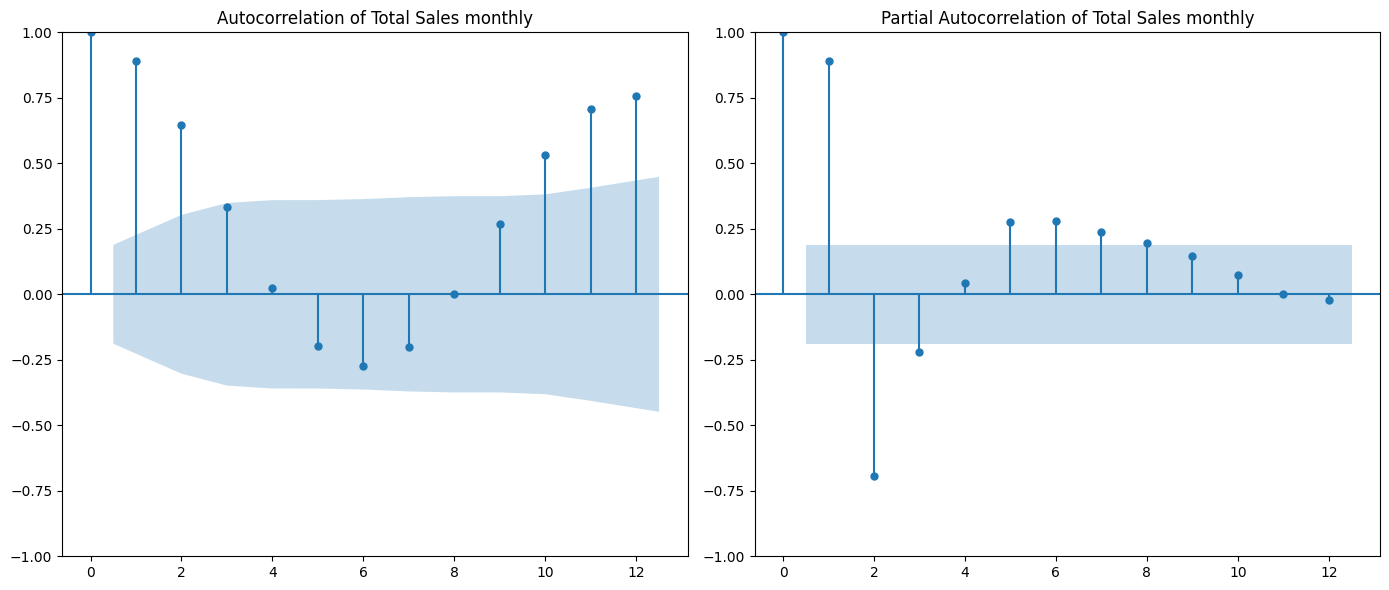

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot autocorrelation and partial autocorrelation for monthly sales data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(monthly_sales, lags=12, ax=plt.gca(), title="Autocorrelation of Total Sales monthly")
plt.subplot(1, 2, 2)
plot_pacf(monthly_sales, lags=12, ax=plt.gca(), title="Partial Autocorrelation of Total Sales monthly")
plt.tight_layout()
plt.show()

## Preparing test

Подоготовим тестовые данные

In [70]:
test = pd.read_csv('test.csv')

In [74]:
test = test.drop(['store', 'product'], axis = 1)

In [75]:
test['Date'] = pd.to_datetime(test['Date'])

In [76]:
test.set_index('Date', inplace=True)

In [77]:
monthly_sales_test = test.resample('ME')['number_sold'].mean()

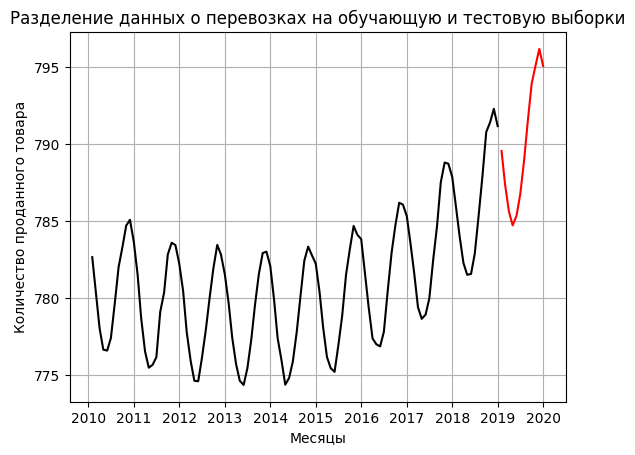

In [81]:
plt.plot(monthly_sales, color = "black")
plt.plot(monthly_sales_test, color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество проданного товара')
plt.xlabel('Месяцы')


plt.grid()
plt.show()

## ARIMA

Для начала попробуем использовать ARIMA

Перебором найдем параметры p, d, q с лучшим AIC

In [ ]:
orders = [(x, y, z) for x in range(1, 7) for y in range(1, 3) for z in range(1, 5)]

aicv = []
models = []

for order in orders:
  model = ARIMA(monthly_sales, order=order).fit()
  models.append(model)
  aicv.append(model.aic)
  print(f'Модель ARIMA{order} - AIC: {model.aic}')

print(f'ЛУЧШИЙ AIC = {orders[np.argmin(aicv)]}')

Модель ARIMA(1, 1, 1) - AIC: 303.402406986245
Модель ARIMA(1, 1, 2) - AIC: 266.58080143847656
Модель ARIMA(1, 1, 3) - AIC: 303.07130125207186
Модель ARIMA(1, 1, 4) - AIC: 246.7311017086055
Модель ARIMA(1, 2, 1) - AIC: 304.7413773877117
Модель ARIMA(1, 2, 2) - AIC: 269.10736811357236
Модель ARIMA(1, 2, 3) - AIC: 268.24761244951037
Модель ARIMA(1, 2, 4) - AIC: 261.4053402044251
Модель ARIMA(2, 1, 1) - AIC: 221.85763727952613
Модель ARIMA(2, 1, 2) - AIC: 120.53428271188041
Модель ARIMA(2, 1, 3) - AIC: 108.83245490953192
Модель ARIMA(2, 1, 4) - AIC: 102.36261632958437
Модель ARIMA(2, 2, 1) - AIC: 288.1507415920881
Модель ARIMA(2, 2, 2) - AIC: 223.36165903464226
Модель ARIMA(2, 2, 3) - AIC: 142.6187716887277
Модель ARIMA(2, 2, 4) - AIC: 63.81824857196981
Модель ARIMA(3, 1, 1) - AIC: 158.6141842943003
Модель ARIMA(3, 1, 2) - AIC: 111.79668149700417
Модель ARIMA(3, 1, 3) - AIC: 117.17170895572764
Модель ARIMA(3, 1, 4) - AIC: 110.46741753792762
Модель ARIMA(3, 2, 1) - AIC: 209.22996315385817
М

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                  108
Model:                 ARIMA(2, 2, 4)   Log Likelihood                 -24.909
Date:                Fri, 15 Nov 2024   AIC                             63.818
Time:                        01:50:53   BIC                             82.462
Sample:                    01-31-2010   HQIC                            71.375
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7319      0.001   2553.854      0.000       1.731       1.733
ar.L2         -0.9999      0.000  -9576.305      0.000      -1.000      -1.000
ma.L1         -3.5299     23.576     -0.150      0.8

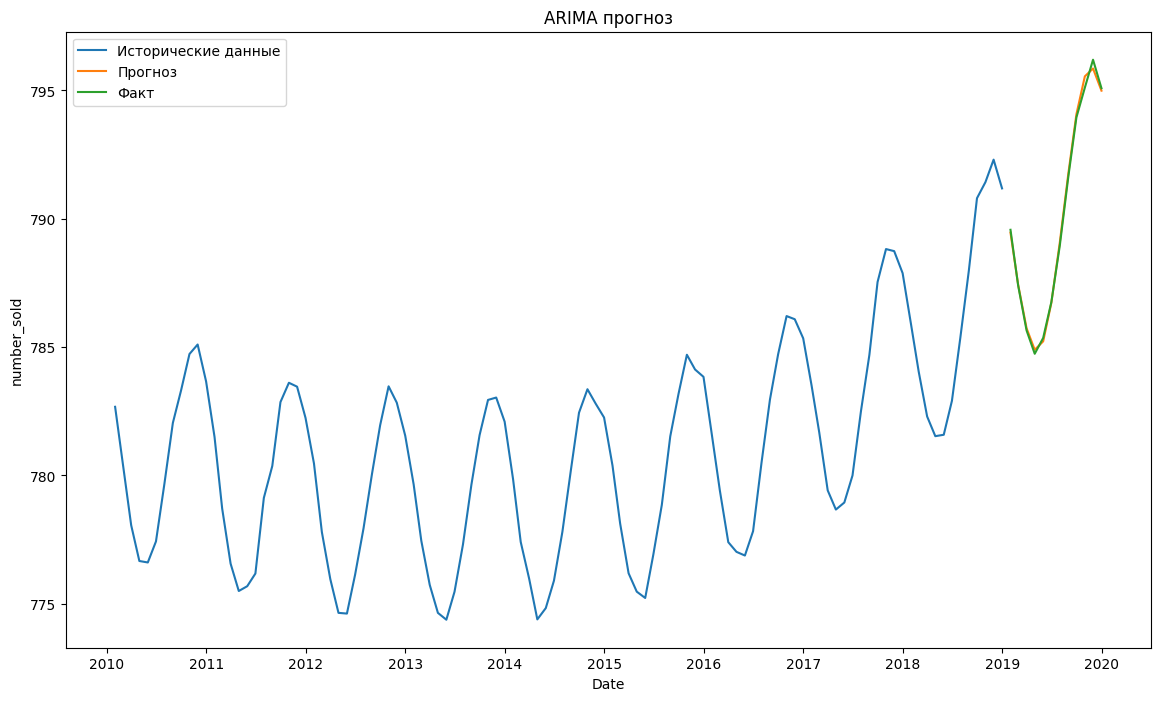

In [144]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(monthly_sales, order=(2,2,4)).fit()
print(model.summary())

# forecast 12 months
forecast = model.predict(start=len(monthly_sales), end=len(monthly_sales)+11)
plt.figure(figsize=(14,8))
sns.lineplot(data=monthly_sales, label='Исторические данные')
sns.lineplot(data=forecast, label='Прогноз')
sns.lineplot(data=monthly_sales_test, label='Факт')
plt.title('ARIMA прогноз')
plt.show()

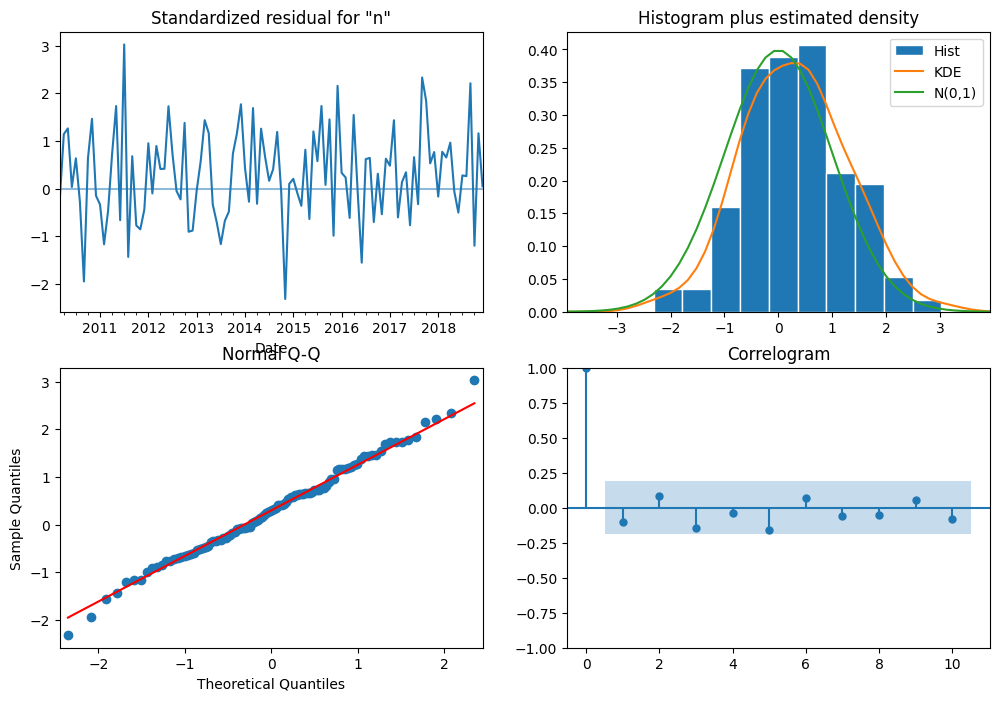

In [145]:
model.plot_diagnostics(figsize=(12, 8))
plt.show()

In [146]:
# импортируем функции метрик
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

# рассчитаем MAPE
print(f'MAPE: {mean_absolute_percentage_error(monthly_sales_test, forecast)}')

# RMSE
print(f'RMSE: {root_mean_squared_error(monthly_sales_test, forecast)}')

# r^2
print(f'r^2: {r2_score(monthly_sales_test, forecast)}')

MAPE: 0.00018774998510664976
RMSE: 0.1884969059696386
r^2: 0.9978167678529417


Метрики получились очень неплохими, в среднем модель ошибается на десятитысячную процента, меньше чем на 1 условную единицу и обобщает даннные на 99 процентов

## SARIMA

Пробуем SARIMA с такими же параметрами

                                      SARIMAX Results                                       
Dep. Variable:                          number_sold   No. Observations:                  108
Model:             SARIMAX(2, 2, 4)x(1, 1, [1], 12)   Log Likelihood                 -17.918
Date:                              Fri, 15 Nov 2024   AIC                             53.837
Time:                                      01:57:51   BIC                             76.726
Sample:                                  01-31-2010   HQIC                            63.083
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9175      0.063    -30.350      0.000      -2.041      -1.794
ar.L2         -0.96

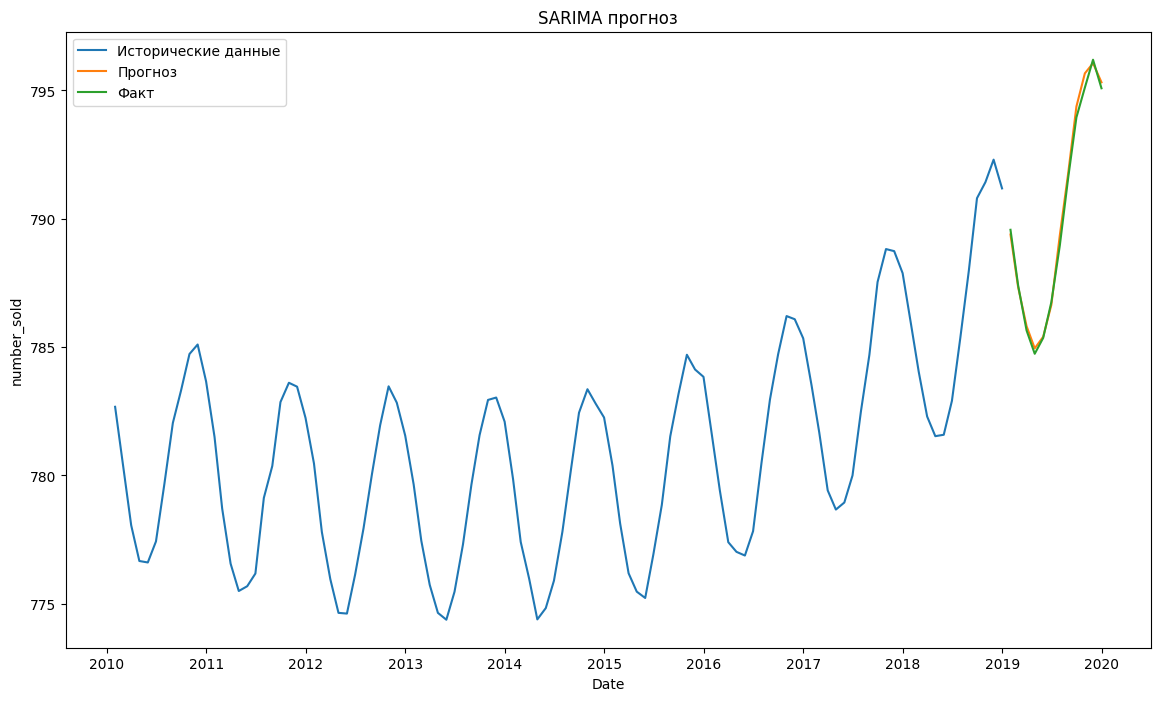

In [150]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(monthly_sales, order=(2,2,4), seasonal_order=(1,1,1,12)).fit()
print(model_sarima.summary())

forecast_sarima = model_sarima.predict(start=len(monthly_sales), end=len(monthly_sales)+11, typ='levels')
plt.figure(figsize=(14,8))
sns.lineplot(data=monthly_sales, label='Исторические данные')
sns.lineplot(data=forecast_sarima, label='Прогноз')
sns.lineplot(data=monthly_sales_test, label='Факт')
plt.title('SARIMA прогноз')
plt.show()

## RESULTS

SARIMA

In [148]:
# импортируем функции метрик
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

# рассчитаем MAPE
print(f'MAPE: {mean_absolute_percentage_error(monthly_sales_test, forecast_sarima)}')

# RMSE
print(f'RMSE: {root_mean_squared_error(monthly_sales_test, forecast_sarima)}')

# r^2
print(f'r^2: {r2_score(monthly_sales_test, forecast_sarima)}')

MAPE: 0.0002842686793825482
RMSE: 0.26953381620705724
r^2: 0.9955360637254748


ARIMA

In [ ]:
# импортируем функции метрик
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

# рассчитаем MAPE
print(f'MAPE: {mean_absolute_percentage_error(monthly_sales_test, forecast)}')

# RMSE
print(f'RMSE: {root_mean_squared_error(monthly_sales_test, forecast)}')

# r^2
print(f'r^2: {r2_score(monthly_sales_test, forecast)}')

MAPE: 0.00018774998510664976
RMSE: 0.1884969059696386
r^2: 0.9978167678529417


Не смотря на то что AIC у SARIMA модели меньше, он немного уступает по выбранным метрикам модели ARIMA (ведь метрики подбирались под ARIMA :) )